# 导入相应的包

In [1]:
from io import open
import unicodedata
import string
import re
import random

import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# 加载数据文件

In [4]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
name = "eng"
sentence = "hello I am Jay"

In [6]:
eng = Lang(name)
eng.addSentence(sentence)

In [7]:
print(eng.word2count)
print(eng.word2index)
print(eng.index2word)
print(eng.n_words)

{'hello': 1, 'I': 1, 'am': 1, 'Jay': 1}
{'hello': 2, 'I': 3, 'am': 4, 'Jay': 5}
{0: 'SOS', 1: 'EOS', 2: 'hello', 3: 'I', 4: 'am', 5: 'Jay'}
6


In [8]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def normalizeString(s):
    # 将传入字符变为小写并去除两侧空白字符，再传入到unicodeToAscii
    s = unicodeToAscii(s.lower().strip())
    # 在.!?的前面加一个空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 将不是字母和标点的都替换为空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
s = "Are you kidding me?"

In [10]:
nsr = normalizeString(s)
print(nsr)

are you kidding me ?


In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    # 读取文件以\n划分，并存到列表lines中
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    # 对lines列表中的句子进行标准化处理，以\t划分成语言对儿
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs 

In [12]:
lang1 = "eng"
lang2 = "fra"
input_lang, output_lang, pairs = readLangs(lang1, lang2)
print("input_lang:", input_lang)
print("output_lang:", output_lang)
print("pairs中的前五个:", pairs[:5])

Reading lines...
input_lang: <__main__.Lang object at 0x000001B27BD9EEB0>
output_lang: <__main__.Lang object at 0x000001B264DE5E50>
pairs中的前五个: [['go .', 'va !'], ['run !', 'cours !'], ['run !', 'courez !'], ['wow !', 'ca alors !'], ['fire !', 'au feu !']]


In [13]:
input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse=True)
print("input_lang:", input_lang)
print("output_lang:", output_lang)
print("pairs中的前五个:", pairs[:5])

Reading lines...
input_lang: <__main__.Lang object at 0x000001B264E37190>
output_lang: <__main__.Lang object at 0x000001B264E37160>
pairs中的前五个: [['va !', 'go .'], ['cours !', 'run !'], ['courez !', 'run !'], ['ca alors !', 'wow !'], ['au feu !', 'fire !']]


In [14]:
# 设置组成句子的最大长度
MAX_LENGTH = 10

# 过滤带有特定前缀的句子用于训练
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# 语言对儿过滤函数，过滤长度以及特定前缀
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and\
        p[1].startswith(eng_prefixes)

# 对语言对列表进行过滤
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [15]:
fpairs = filterPairs(pairs)
print("过滤后的pairs前五个:", fpairs[:5])

过滤后的pairs前五个: [['j ai ans .', 'i m .'], ['je vais bien .', 'i m ok .'], ['ca va .', 'i m ok .'], ['je suis gras .', 'i m fat .'], ['je suis gros .', 'i m fat .']]


In [16]:
# 准备数据函数
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    # 遍历每一个句子，建立单词表
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis desolee de vous avoir mal compris .', 'i m sorry i misunderstood you .']


# Seq2Seq 模型
## 编码器

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        input_size代表编码器的输入尺寸，即源语言的词表大小
        hidden_size代表GRU隐层结点个数，也是词嵌入的维度，也是GRU的输入尺寸
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 解码器
### 简单的解码器

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        """
        hidden_size代表解码器中GRU输入尺寸，也是隐层节点数
        output_size代表输出尺寸，也是目标语言词表大小
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 注意力解码器

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
        hidden_size代表解码器中GRU输入尺寸，也是隐层节点数
        output_size代表输出尺寸，也是目标语言词表大小
        dropout_p为dropout的概率
        max_length为句子最大长度
        """
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length) # Q，K做拼接之后线性变换
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0],attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 训练
## 准备训练数据

In [20]:
def indexexFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexexFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [21]:
pair = pairs[5]
pair

['je suis en forme .', 'i m fit .']

In [22]:
pair_tensor = tensorsFromPair(pair)

In [23]:
pair_tensor

(tensor([[ 6],
         [11],
         [14],
         [15],
         [ 5],
         [ 1]], device='cuda:0'),
 tensor([[2],
         [3],
         [7],
         [4],
         [1]], device='cuda:0'))

## 训练模型

In [24]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # 使用teacher_forcing
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # 未使用teacher_forcing
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [25]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since # 运行了多少秒
    es = s / percent # 预估总共多少秒
    rs = es - s # 还需要多少秒
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
since = time.time() - 10 * 60

In [27]:
period = timeSince(since, 1)
period

'10m 0s (- 0m 0s)'

In [28]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                        iter, iter / n_iters * 100, print_loss_avg))
            
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

2m 52s (- 54m 32s) (5000 5%) 2.7670
5m 22s (- 48m 19s) (10000 10%) 2.1351
7m 53s (- 44m 43s) (15000 15%) 1.7443
10m 26s (- 41m 45s) (20000 20%) 1.4394
12m 59s (- 38m 59s) (25000 25%) 1.1715
15m 31s (- 36m 14s) (30000 30%) 1.0099
18m 3s (- 33m 32s) (35000 35%) 0.8444
20m 40s (- 31m 0s) (40000 40%) 0.7230
23m 14s (- 28m 24s) (45000 45%) 0.6176
25m 48s (- 25m 48s) (50000 50%) 0.5188
28m 22s (- 23m 13s) (55000 55%) 0.4567
30m 54s (- 20m 36s) (60000 60%) 0.4013
33m 26s (- 18m 0s) (65000 65%) 0.3555
36m 4s (- 15m 27s) (70000 70%) 0.3091
38m 46s (- 12m 55s) (75000 75%) 0.2962
41m 22s (- 10m 20s) (80000 80%) 0.2382
43m 58s (- 7m 45s) (85000 85%) 0.2223
46m 38s (- 5m 10s) (90000 90%) 0.2037
49m 13s (- 2m 35s) (95000 95%) 0.1809
51m 56s (- 0m 0s) (100000 100%) 0.1664


<Figure size 432x288 with 0 Axes>

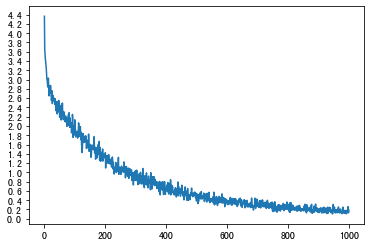

In [30]:
hidden_size = 512
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, attn_decoder, 100000, print_every=5000)

In [31]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()
            
        # di+1即为拿到当前运行到的di步的注意力张量即可
        return decoded_words, decoder_attentions[:di + 1]

In [32]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [33]:
evaluateRandomly(encoder, attn_decoder)

> il est respecte par tout le monde .
= he is respected by everyone .
< he is respected by everybody . <EOS>

> tu as probablement tort .
= you are probably wrong .
< you are probably wrong . <EOS>

> je compte devenir ingenieur .
= i am going to be an engineer .
< i am going to be an engineer . <EOS>

> j y compte .
= i m counting on it .
< i m counting on it . <EOS>

> il n est pas a la maison .
= he isn t at home .
< he s not at home . <EOS>

> j en ai assez d ecouter tes rodomontades .
= i m tired of listening to your bragging .
< i m tired of listening to your bragging . <EOS>

> tu es parfois si puerile .
= you are so childish sometimes .
< you are so childish sometimes . <EOS>

> nous faisons tout ce que nous pouvons .
= we re doing all we can .
< we re doing all we can . <EOS>

> je lis un magazine .
= i am reading a magazine .
< i am reading a magazine . <EOS>

> vous etes pleines de ressources .
= you re very resourceful .
< you re very resourceful . <EOS>



# 可视化注意力

In [34]:
output_words, attentions = evaluate(
    encoder, attn_decoder, "il a l habitude des ordinateurs")

In [35]:
output_words = ' '.join(output_words)
output_words

'he is familiar with computers . <EOS>'

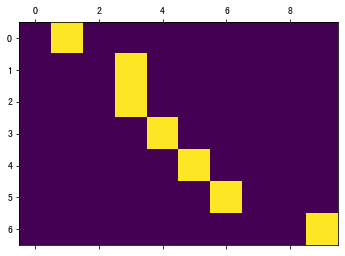

In [36]:
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than i am . <EOS>


C:\Users\WSA51\AppData\Local\Temp/ipykernel_22636/544125841.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\WSA51\AppData\Local\Temp/ipykernel_22636/544125841.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


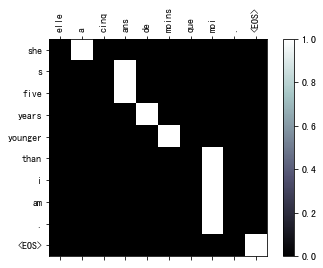

input = elle est trop petit .
output = she s too short . <EOS>


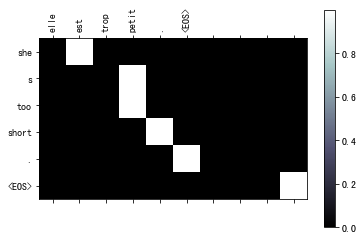

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


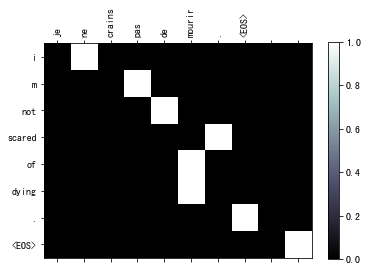

input = c est un jeune directeur plein de talent .
output = he s a talented young . <EOS>


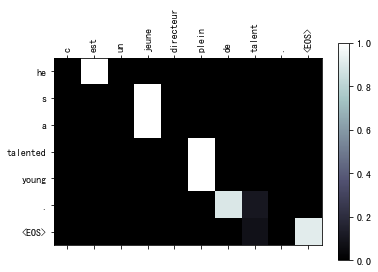

In [50]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")


In [51]:
torch.save(encoder, 'encoder_weights.pt')
torch.save(attn_decoder, 'attn_decoder_weights.pt')